### Exploring pairs trading

trying to learn more about quant finance

using these slides for pairs trading, thx @nik_algo on twitter

https://palomar.home.ece.ust.hk/MAFS5310_lectures/slides_pairs_trading.pdf

gonna work through his slides using s&p500 company data


#### data gathering

In [243]:
import pandas as pd
import yfinance
import numpy as np
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import adfuller
from scipy import stats
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
table = pd.read_html(
    'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
df = table[0]
df.head()

,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,reports,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,66740,1902
1,AOS,A. O. Smith,reports,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
3,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [13]:
symbols = ' '.join(df['Symbol'])
symbols[:100]
data = yfinance.download(
    tickers = symbols,
    period = "1y",
    interval = '1h',
    ignore_tz = True,
    prepost = False
)

[*********************100%***********************]  503 of 503 completed

2 Failed downloads:
- BRK.B: No data found, symbol may be delisted
- BF.B: No data found for this date range, symbol may be delisted


In [97]:
data.head()

print(data.astype(bool).sum(axis=1).value_counts())
log_prices = data['Adj Close'].copy()
for c in log_prices.columns:
    log_prices[c] = np.log10(log_prices[c] + 0.001)
log_prices.fillna(method='backfill',inplace=True)
log_prices.dropna(axis=1,inplace=True)

3018    1629
3017      65
3016      29
3015      16
3014       8
3013       4
2530       1
3011       1
3012       1
2518       1
3004       1
dtype: int64


In [98]:
print(log_prices.iloc[:5,:5])

                            A       AAL       AAP      AAPL      ABBV
2022-02-01 12:30:00  2.144873  1.226497  2.367227  2.238074  2.134573
2022-02-01 13:30:00  2.143518  1.224300  2.368289  2.238281  2.134754
2022-02-01 14:30:00  2.146519  1.224300  2.369867  2.240869  2.136534
2022-02-01 15:30:00  2.149438  1.225852  2.370644  2.242072  2.136692
2022-02-02 09:30:00  2.156764  1.221962  2.367507  2.243115  2.139000


In [99]:
print(log_prices.corr().iloc[:5,:5])

             A       AAL       AAP      AAPL      ABBV
A     1.000000 -0.037495 -0.470413 -0.117031  0.334234
AAL  -0.037495  1.000000  0.646456  0.542250  0.209773
AAP  -0.470413  0.646456  1.000000  0.767594 -0.110215
AAPL -0.117031  0.542250  0.767594  1.000000 -0.142303
ABBV  0.334234  0.209773 -0.110215 -0.142303  1.000000


#### Pair selection

In [100]:
rough_cointegration_values = []
for i,c in enumerate(log_prices.columns):
    for c1 in log_prices.columns[i + 1:]:
        diff = np.sum(np.square(log_prices[c] - log_prices[c1]))
        rough_cointegration_values.append((diff,c,c1))
coints = pd.DataFrame(rough_cointegration_values,columns=['rough_coint','ticker_A','ticker_B'])


In [101]:
coints = coints[coints['rough_coint'] != 0.0]
coints.sort_values('rough_coint').head(10)

,rough_coint,ticker_A,ticker_B
81294,0.011695,GOOG,GOOGL
112530,0.077553,NWS,NWSA
45516,0.241819,CMS,EVRG
7858,0.279268,AEP,WEC
21175,0.317918,ATO,ETR
121586,0.332246,SO,XEL
21558,0.345328,ATVI,CL
117210,0.366880,PNR,USB
7529,0.385582,AEP,ED
45708,0.387750,CMS,PEG


#### Cointegration test

In [121]:
test_data = log_prices[['CMS',"EVRG"]]
X = np.vstack([np.ones(len(test_data)),test_data['CMS']]).T
y = test_data['EVRG'].to_numpy()
mu, gamma = np.dot(np.linalg.pinv(X),y)

<AxesSubplot: ylabel='Frequency'>

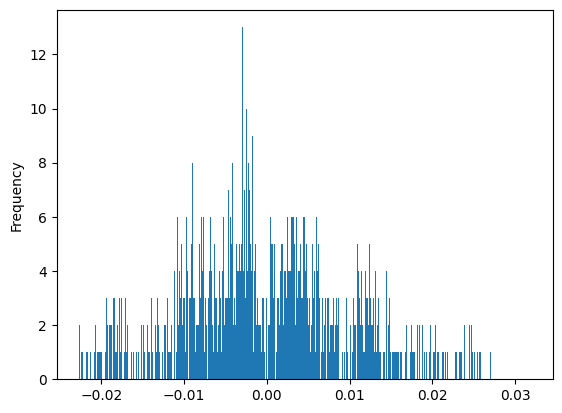

In [135]:
residuals:pd.DataFrame = test_data['EVRG'] - gamma * test_data['CMS'] - mu
adfuller(residuals)
residuals.plot.hist(bins=1000)

#### Optimum threshold

(-7.456631294996296, 313.0370394687247)

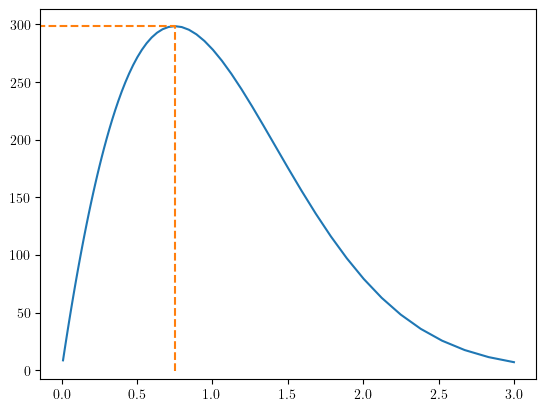

In [244]:
x = np.geomspace(0.01,3,100)
y = x * len(residuals) * (1 - stats.norm.cdf(x))
plt.plot(x,y)
amax = np.argmax(y)
xlim,ylim = plt.xlim(), plt.ylim()
plt.plot([x[amax], x[amax], xlim[0]], [xlim[0], y[amax], y[amax]],
          linestyle="--")
plt.xlim(xlim)
plt.ylim(ylim)

/var/folders/jr/0bg6njgs6rs81lwz018d85bm0000gn/T/ipykernel_14624/2388216304.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['spread'] = test_data['CMS'] - test_data['EVRG']


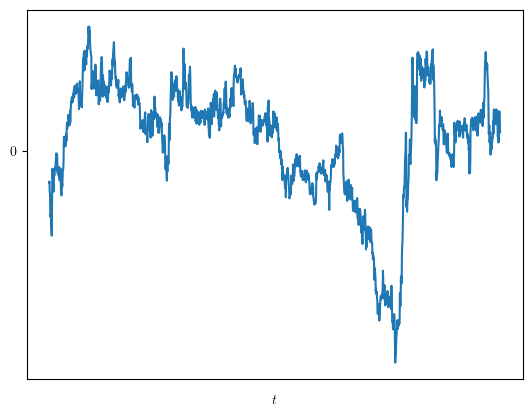

In [189]:
test_data['spread'] = test_data['CMS'] - test_data['EVRG']
fig,ax = plt.subplots()
ax.set_xticklabels([])
ax.tick_params(bottom=False)
ax.set_xlabel(r'$t$')
ax.set_yticks([0.0])
ax.plot(range(len(test_data)),test_data['spread'])

In [227]:
def cmp(a, b):
    return (a > b) ^ (a < b)

def check_zero_crossing(p1,p2):
    return (p1 < 0 and p2 > 0) or (p1 > 0 and p2 < 0)


def profit_check(df,s):
    openLeg = 0.0
    profit = 0.0
    trades = []
    prev = cmp(df['spread'][0],0)
    for i,spread in enumerate(df['spread']):
        if (spread > s  or spread < -s) and openLeg == 0.0:
            openLeg = spread
            trades.append(i)
        if check_zero_crossing(prev,spread):
            profit += abs(openLeg)
            openLeg = 0.0
        prev = spread
    return profit,trades


        
profit_check(test_data,0.01)


(0.08481593488118522, [4, 88, 473, 1032, 1182, 1391, 1412, 1694])

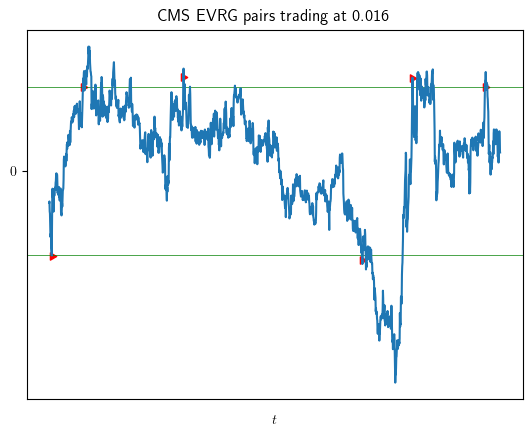

In [251]:
s = 0.016
profit,trades = profit_check(test_data,s)
fig,ax = plt.subplots()
ax.set_xticklabels([])
ax.tick_params(bottom=False)
ax.set_xlabel(r'$t$')
ax.set_yticks([0.0])
ax.axhline(y=s,lw=0.5,c='g')
ax.axhline(y=-s,lw=0.5,c='g')
ax.set_title(f"CMS EVRG pairs trading at {s}")
ax.plot(range(len(test_data)),test_data['spread'])
ax.scatter(trades,test_data['spread'][trades],marker=(3,0,270),c='red')

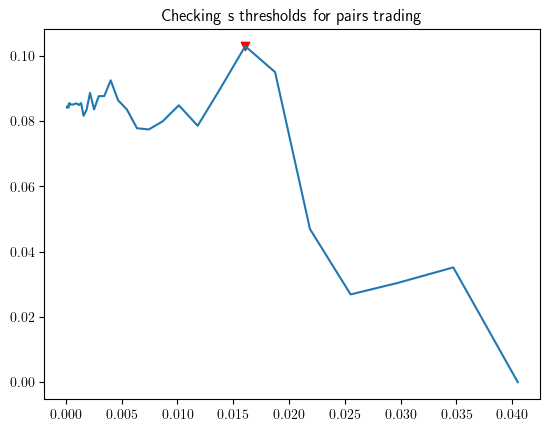

In [242]:
max_spread = max(test_data['spread'].abs())
tests = np.geomspace(0.0001,max_spread,40)
profits,trades = zip(*[profit_check(test_data,t) for t in tests])
fig,ax = plt.subplots()
ax.set_title("Checking s thresholds for pairs trading")
ax.set_xticks
ax.plot(tests,profits)
ax.scatter(tests[np.argmax(profits)],max(profits),marker='v',c='r')

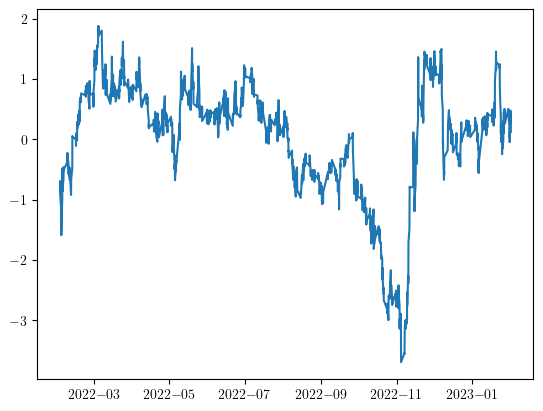

In [255]:
z_score_spread = stats.zscore(test_data['spread'])
fig,ax = plt.subplots()
ax.plot(test_data.index,z_score_spread)